In [1]:
from extract_templates import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import seaborn as sns

sns.set(style="ticks", palette="colorblind")

In [2]:
all_templates = list()
for i in range(12):
    all_templates.append(np.load("{}_templates.npy".format(i + 1)))

all_expanded_templates = list()
for i, tpls in enumerate(all_templates):
    all_expanded_templates.append(
        [
            scipy.interpolate.interp1d(
                np.linspace(0, 1, num=tpls.shape[1]),
                tpls[i, :],
                kind="cubic",
            )
            for i in range(tpls.shape[0])
        ]
    )

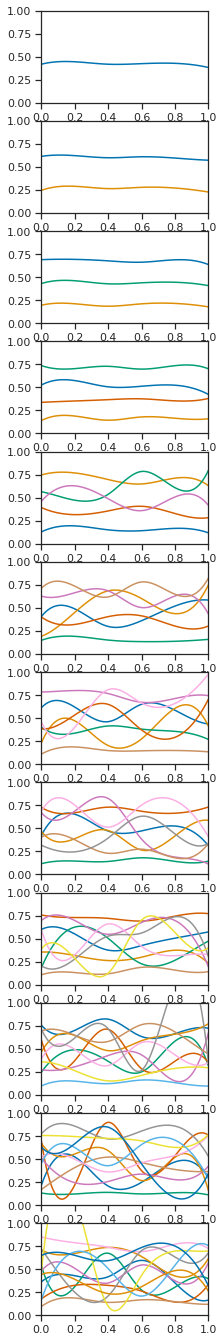

In [3]:
fig, axarr = plt.subplots(
    len(all_expanded_templates), 1, figsize=(3, 2 * len(all_expanded_templates))
)
x = np.linspace(0, 1, 100)
for i, tpls in enumerate(all_expanded_templates):
    for tpl in tpls:
        axarr[i].plot(x, [tpl(v) for v in x])
    axarr[i].set_xlim(0, 1)
    axarr[i].set_ylim(0, 1)